# Forecasting solar flares using recurring neural networks for multi-class classification
***


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, Model, Input
#from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
import keras

#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit RNN
***

In [4]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [5]:
# Analyze flare distribution over time

# Number of flare-days per year
df_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum'])
print(df_flares)

        sum
DATE       
2010    8.0
2011   65.0
2012   79.0
2013   68.0
2014  118.0
2015   68.0
2016   11.0
2017   15.0
2018    0.0
2019    0.0
2020    2.0
2021   21.0
2022   92.0
2023    8.0


In [6]:
# Number of days with flares (count should be 8760 [24*365] or 8784 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with flare distribution by year:")
print(yearly_flares)


Days with flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [7]:
# Function for the multi-class feature

def label_from_counts(row):
    if row["Flares: X"] > 0:
        return 3
    elif row["Flares: M"] > 0:
        return 2
    elif row["Flares: C"] > 0:
        return 1
    else:
        return 0

df["flare_class"] = df.apply(label_from_counts, axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [8]:
# The dataset is too big to run the hyperparameter opitmization in my PC, so I am going to use a sample for this part
df_short = df.sample(frac=1.00)
print(df_short.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4480 entries, 3622 to 1461
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64           

In [9]:
# chronological split is important for time series
df_short = df_short.sort_values('DATE').reset_index(drop=True)
assert df_short['DATE'].is_monotonic_increasing

print(df_short.head())

                       DATE        USFLUX    MEANGAM     MEANGBT     MEANGBZ  \
0 2010-05-01 00:00:00+00:00  2.325578e+21  29.580376  121.361911  123.196711   
1 2010-05-02 00:00:00+00:00  2.699988e+21  28.754651  122.189762  122.241274   
2 2010-05-03 00:00:00+00:00  2.737004e+21  32.654695  114.207593  116.857353   
3 2010-05-04 00:00:00+00:00  3.460735e+21  29.845298  111.707230  113.253585   
4 2010-05-05 00:00:00+00:00  4.497098e+21  32.732238  114.995095  116.684410   

     MEANGBH   MEANJZD       TOTUSJZ   MEANALP   MEANJZH  ...  \
0  51.438868  0.322770  2.560842e+12 -0.003638 -0.001203  ...   
1  49.093493  0.482670  2.708962e+12 -0.007883 -0.001898  ...   
2  50.317212  0.219577  3.095129e+12 -0.002852 -0.000701  ...   
3  47.297438  0.145063  3.903967e+12 -0.015477 -0.005461  ...   
4  53.376813  0.285346  5.270056e+12 -0.019851 -0.008012  ...   

   Radio Flux 10.7cm  Sunspot Number  Sunspot Area (10^6 Hemis.)  New Regions  \
0               78.0            13.0           

In [10]:
# let's check all columns to drop some on the next step
print(df_short.columns)

Index(['DATE', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE', 'xrs_A_mean',
       'xrs_A_min', 'xrs_A_max', 'xrs_B_mean', 'xrs_B_min', 'xrs_B_max',
       'Radio Flux 10.7cm', 'Sunspot Number', 'Sunspot Area (10^6 Hemis.)',
       'New Regions', 'Flares: C', 'Flares: M', 'Flares: X', 'flare_today',
       'flare_missing', 'flare_class'],
      dtype='object')


# Fitting the model
***

In [12]:
# Separate features and target
feature_cols = [col for col in df.columns 
                if col not in ['DATE', "Flares: C", "Flares: M", "Flares: X", "flare_class", "flare_today", "flare_missing"]]

X = df_short[feature_cols].values
y = df_short["flare_class"].values

print(X.shape, y.shape)

(4480, 27) (4480,)


In [13]:
# Build sequences (last N days)

T = 3

def build_sequences(X, y, T):
    Xs, ys = [], []
    for i in range(len(X) - T):
        seq = X[i:i+T]
        target = y[i+T]
        Xs.append(seq)
        ys.append(target)
    return np.array(Xs), np.array(ys)

X_seq, y_seq = build_sequences(X, y, T)

In [19]:
# Split into train and test sets
# Time series should not be randomly shuffled.

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 3581
Test samples: 896

Class distribution in training set:
[[   0 1878]
 [   1 1270]
 [   2  389]
 [   3   44]]
Percentage of positive cases in train: 60.88%

Class distribution in test set:
[[  0 415]
 [  1 359]
 [  2 110]
 [  3  12]]
Percentage of positive cases in test: 68.64%


In [20]:
# Scale features
scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

In [21]:
# Compute class weights for flare class imbalance

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
class_weight_dict

{0: 0.47670394036208735,
 1: 0.7049212598425196,
 2: 2.301413881748072,
 3: 20.34659090909091}

In [ ]:
# Apply SMOTE to balance the training data
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

#print(f"\nAfter SMOTE:")
#print(f"Training samples: {len(X_train_balanced)}")
#print(pd.Series(y_train_balanced).value_counts())

In [35]:
# you can just load the model if already trained and not run the grid search and best model again
# in that case, do not run the next cells
best_model = load_model('../data/flares_keras_RNN.keras')

In [23]:
# Adapt the model to classification only

def build_flares_model(hparams):

    units = hparams["units"]
    dropout = hparams["dropout"]
    layers_n = hparams["num_layers"]
    lr = hparams["lr"]

    inp = Input(shape=(hparams["timesteps"], hparams["features"]))
    x = inp

    """for i in range(layers_n):
        return_sequences = (i < layers_n - 1)
        x = layers.LSTM(units, return_sequences=return_sequences)(x)
        x = layers.Dropout(dropout)(x)"""

    for i in range(layers_n):
        return_sequences = (i < layers_n - 1)
        x = layers.GRU(units, return_sequences=return_sequences)(x)
        x = layers.Dropout(dropout)(x)


    out = layers.Dense(hparams["num_classes"], activation="softmax")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [24]:
# Tune hyperparameters

num_classes = len(np.unique(y_train))

def flares_model_builder(hp):

    hparams = {
        "units": hp.Choice("units", [32, 64, 128]),
        "dropout": hp.Float("dropout", 0.1, 0.5, step=0.1),
        "num_layers": hp.Choice("num_layers", [1, 2, 3]),
        "lr": hp.Choice("lr", [1e-4, 3e-4, 1e-3]),
        "timesteps": X_train_scaled.shape[1],
        "features": X_train_scaled.shape[2],
        "num_classes": num_classes
    }

    return build_flares_model(hparams)

In [ ]:
# Run tuner (it may take a while...)

tuner = kt.RandomSearch(
    hypermodel=flares_model_builder,
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="flare_tuning",
    project_name="rnn_flares"
)

tuner.search(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict,
    epochs=40,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True
    )]
)

Trial 20 Complete [00h 00m 22s]
val_accuracy: 0.6026785969734192

Best val_accuracy So Far: 0.6629464030265808
Total elapsed time: 00h 04m 22s


In [26]:
# Train with best model
best_model = tuner.get_best_models(1)[0]

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True
    )]
)

Epoch 1/50


c:\Users\fdesm\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6108 - loss: 0.9770 - val_accuracy: 0.9777 - val_loss: 0.1277
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6316 - loss: 0.9602 - val_accuracy: 0.9721 - val_loss: 0.1323
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6241 - loss: 0.9611 - val_accuracy: 0.9554 - val_loss: 0.1512
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6220 - loss: 0.9533 - val_accuracy: 0.9666 - val_loss: 0.1405
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6421 - loss: 0.9515 - val_accuracy: 0.9582 - val_loss: 0.1586
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6347 - loss: 0.9190 - val_accuracy: 0.9526 - val_loss: 0.1522


In [29]:
# evaluate
results = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(best_model.metrics_names, results)))

{'loss': 0.7947500348091125, 'compile_metrics': 0.65625}


In [30]:
# Save the best model
best_model.save("../data/flares_keras_RNN.keras")
print("Best model saved to ../data/flares_keras_RNN.keras")

Best model saved to ../data/flares_keras_RNN.keras


In [31]:
# Predict
y_pred_proba = best_model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [44]:
# Predict (do NOT ravel multi-class outputs)
y_pred_proba = best_model.predict(X_test_scaled)   # shape (n_samples, n_classes) for multi-class
if y_pred_proba.ndim > 1:
    # multi-class: take class with highest probability
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
else:
    # binary: threshold the single probability output
    y_pred_labels = (y_pred_proba.ravel() >= 0.5).astype(int)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# Results
***

In [45]:
# quick debug: print shapes
print("len(y_test) =", len(y_test), "len(y_pred_labels) =", len(y_pred_labels))
print("y_test.ndim =", y_test.ndim, "y_pred_labels.ndim =", np.asarray(y_pred_labels).ndim)

len(y_test) = 896 len(y_pred_labels) = 896
y_test.ndim = 1 y_pred_labels.ndim = 1


In [60]:
# Metrics

# 1. Probabilities from NN
y_pred_proba = best_model.predict(X_test)

# 2. Convert to binary labels
y_pred = (y_pred_proba >= 0.5).astype(int)

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("\nConfusion Matrix:")
print(cm)

# 4. Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

# 5. Additional metrics
if len(np.unique(y_test)) > 1:
    f2 = fbeta_score(y_test, y_pred_labels, beta=2, average='weighted')
    f1 = fbeta_score(y_test, y_pred_labels, beta=1, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    avg_prec = average_precision_score(y_test, y_pred_proba, average="macro")
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2, f1, recall, avg_prec, roc_auc]
    })

    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Confusion Matrix:
[[380  33   1   1]
 [112 176  54  17]
 [ 10  42  28  30]
 [  1   2   5   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       415
           1       0.70      0.49      0.58       359
           2       0.32      0.25      0.28       110
           3       0.08      0.33      0.12        12

    accuracy                           0.66       896
   macro avg       0.46      0.50      0.45       896
weighted avg       0.67      0.66      0.65       896


Evaluation Metrics:
       Metric  Score
           F2 0.6508
           F1 0.6503
       Recall 0.6562
Avg Precision 0.2543
      ROC AUC 0.4447



Visualization saved as 'solar_flare_RNN_results.png'


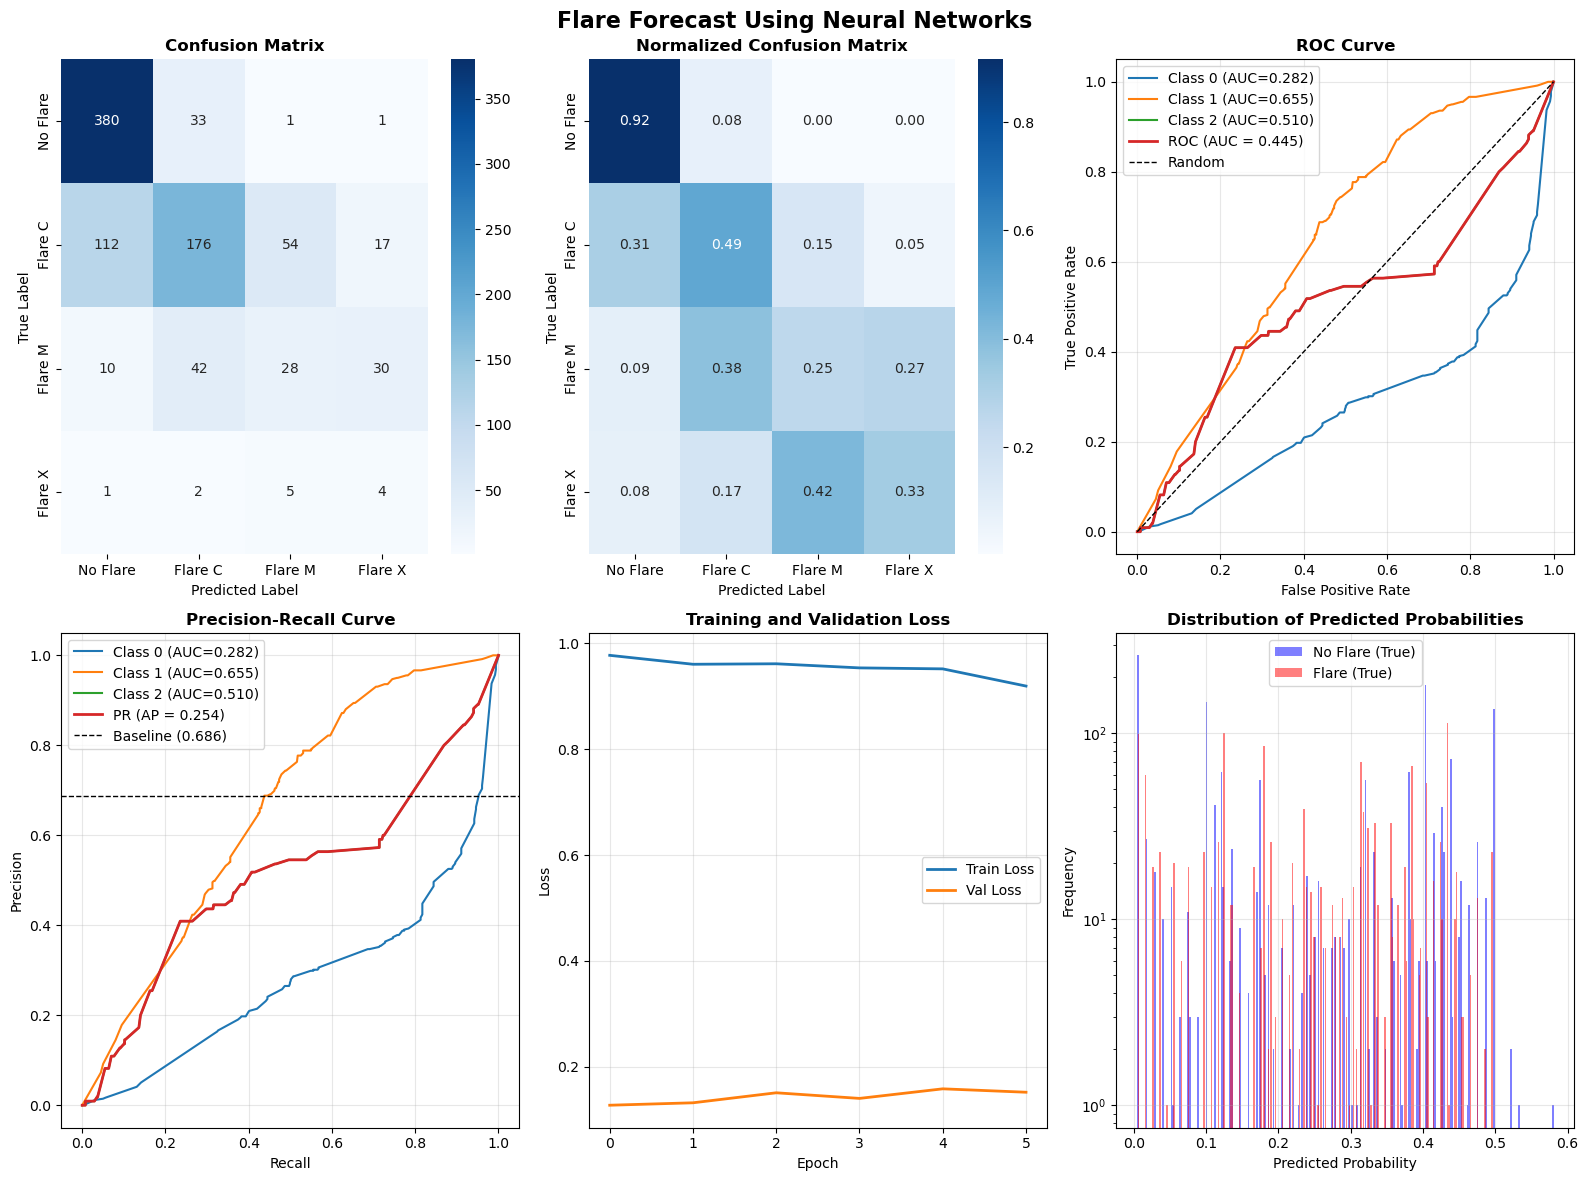

In [72]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare C', 'Flare M', 'Flare X']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve

if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)

    # binarize true labels
    y_test_bin = label_binarize(y_test, classes=[0,1,2]) # C=0, M=1, X=2

    for i in range(3):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        ax3.plot(fpr, tpr, label=f'Class {i} (AUC={auc(fpr, tpr):.3f})')
    
    #fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)

    for i in range(3):
        recall, precision, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        ax4.plot(recall, precision, label=f'Class {i} (AUC={auc(recall, precision):.3f})')

    #precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_prec:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color=['blue', 'blue', 'blue', 'blue'])
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color=['red', 'red', 'red', 'red'])
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_RNN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_RNN_results.png'")
plt.show()